## Make classicfication data and get it ready


In [1]:
import sklearn
import numpy as np

In [2]:
from sklearn.datasets import make_circles
n_samples=1000

X,y=make_circles(n_samples,
                 noise=0.003,
                random_state=42)

In [3]:
len(X),len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of x:{X[:5]}")
print(f"First 5 samples of y:{y[:5]}")


First 5 samples of x:[[ 0.77049941  0.21095396]
 [-0.78602977  0.13242465]
 [-0.79586178  0.10756813]
 [-0.34593416  0.72076375]
 [ 0.43762495 -0.89913707]]
First 5 samples of y:[1 1 1 1 0]


In [5]:
import pandas as pd
circles=pd.DataFrame({"X1":X[:,0],
                      "X2":X[:,1],
                      "label":y})
circles.head(10)

,X1,X2,label
0,0.770499,0.210954,1
1,-0.786030,0.132425,1
2,-0.795862,0.107568,1
3,-0.345934,0.720764,1
4,0.437625,-0.899137,0
5,-0.492824,0.633771,1
6,-0.010412,0.800278,1
7,0.787565,0.131875,1
8,-0.160723,-0.784841,1
9,-0.136160,0.993566,0


In [6]:
import matplotlib.pyplot as plt

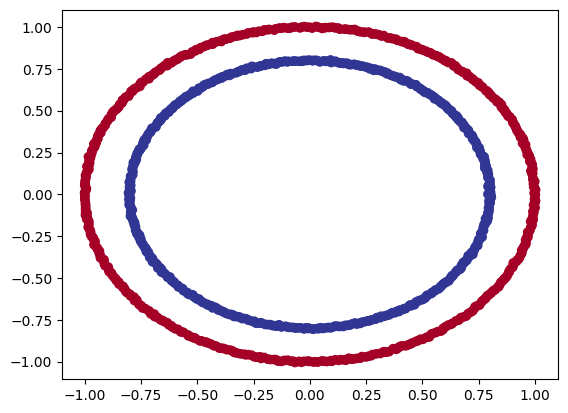

In [7]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
import torch
torch.__version__

'2.1.0+cu118'

In [10]:
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

X[:5],y[:5]

(tensor([[ 0.7705,  0.2110],
         [-0.7860,  0.1324],
         [-0.7959,  0.1076],
         [-0.3459,  0.7208],
         [ 0.4376, -0.8991]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
type(X),X.dtype,y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [12]:
#split data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.2,
                                               random_state=42)
len(X_train),len(X_test)

(800, 200)

##Building our Model

1. set up device agnostic code so our code will run on an accelerator(GPU) if there is one
2. Construct a model(by subclassing nn.Module)
3. Define a loss functon and optimizer
4. Create a trainig and testing loop

In [13]:
import torch
from torch import nn
#Make device agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
class circleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    #create 2 nn.linear layers capable of handling the shapes of our data
    self.layer_1=nn.Linear(in_features=2,out_features=5)
    self.layer_2=nn.Linear(in_features=5,out_features=1)


  def forward(self,x):
    return self.layer_2(self.layer_1(x))#x->layer 1->layer 2
#Instantiate an instance of our model class and send it to the target device
model_0=circleModelV0().to(device)
model_0

circleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
device

'cuda'

In [16]:
#Lets replicate the model using nn.Sequential
model_0=nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2962,  0.4642],
                      [-0.6953,  0.0501],
                      [ 0.3910, -0.2389],
                      [ 0.1516, -0.2965],
                      [-0.4057,  0.5697]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.6234,  0.5031,  0.4957, -0.2734,  0.5016], device='cuda:0')),
             ('1.weight',
              tensor([[-0.1715, -0.2501, -0.0193,  0.1806,  0.0483]], device='cuda:0')),
             ('1.bias', tensor([-0.1474], device='cuda:0'))])

In [18]:
untrained_pred=model_0(X_test.to(device))
print(f"Length of predictions:{len(untrained_pred)}, Shape:{untrained_pred.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_pred[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions:200, Shape:torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.5422],
        [-0.5332],
        [-0.4669],
        [-0.5627],
        [-0.2849],
        [-0.2801],
        [-0.3771],
        [-0.3148],
        [-0.4839],
        [-0.5203]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [19]:
## Set up loss function and optimizer
loss_fn=nn.BCEWithLogitsLoss()#sigmoid activation function builtin
optimizer=torch.optim.SGD(params=model_0.parameters(),
                          lr=0.1)



In [20]:
def accuracy_fn(y_true,y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()
  acc=(correct/len(y_pred))*100
  return acc

Training and Testing Loop

In [21]:
torch.manual_seed(42)
epochs=100
X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  y_logits=model_0(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_train,y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ##Testing
  model_0.eval()
  with torch.inference_mode():
    test_logits=model_0(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_test,test_pred)

  if epoch%10==0:
    print(f"Epoch:{epoch}|Loss:{loss:.5f},Accuracy:{acc:.2f}%|Test Loss:{test_loss:.5f},Test acc:{test_acc:.2f}")

Epoch:0|Loss:0.71602,Accuracy:50.00%|Test Loss:0.71285,Test acc:50.00
Epoch:10|Loss:0.70008,Accuracy:50.00%|Test Loss:0.69928,Test acc:50.00
Epoch:20|Loss:0.69525,Accuracy:50.00%|Test Loss:0.69545,Test acc:50.00
Epoch:30|Loss:0.69376,Accuracy:46.50%|Test Loss:0.69443,Test acc:44.00
Epoch:40|Loss:0.69328,Accuracy:47.88%|Test Loss:0.69420,Test acc:44.50
Epoch:50|Loss:0.69313,Accuracy:48.38%|Test Loss:0.69418,Test acc:50.50
Epoch:60|Loss:0.69307,Accuracy:49.38%|Test Loss:0.69421,Test acc:49.50
Epoch:70|Loss:0.69304,Accuracy:50.38%|Test Loss:0.69424,Test acc:48.00
Epoch:80|Loss:0.69303,Accuracy:50.25%|Test Loss:0.69427,Test acc:49.00
Epoch:90|Loss:0.69302,Accuracy:50.75%|Test Loss:0.69429,Test acc:47.50


In [22]:
import requests
from pathlib import Path
#Download helper functionf(if its already not downloaded)
if Path("helper_function.py").is_file():
  print("helper_function.py already exists")
else:
  print("Downloading helper_function.py")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_function.py","wb") as f:
    f.write(request.content)
from helper_function import plot_predictions, plot_decision_boundary

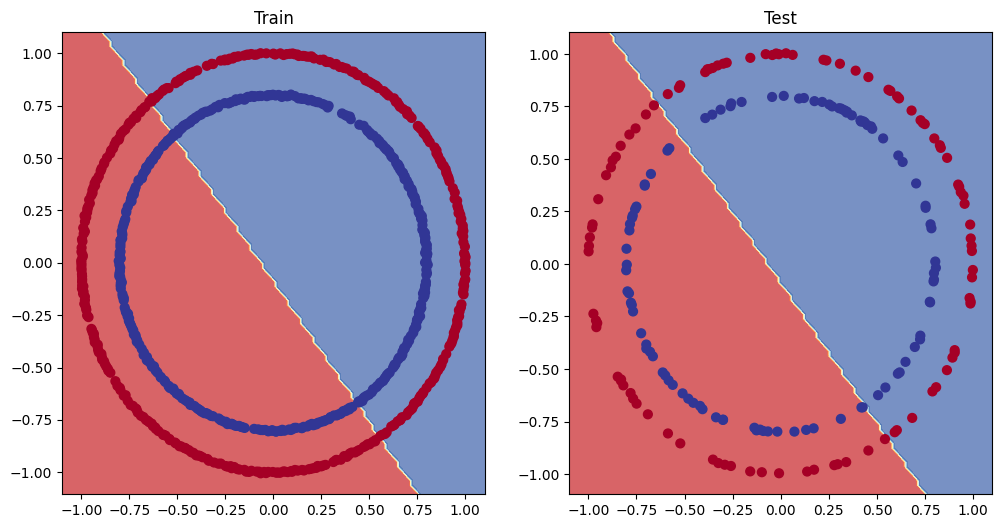

In [23]:
#Plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)


Adding Non-Linearity


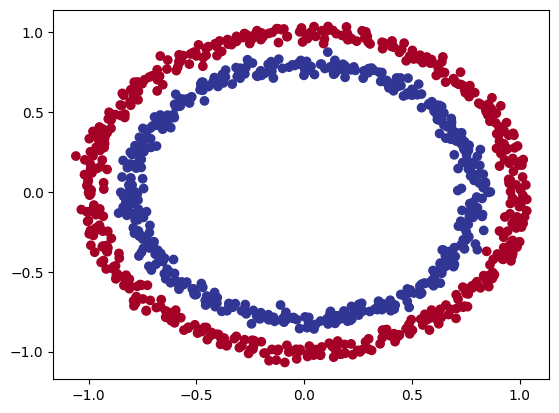

In [24]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples=1000
X,y=make_circles(n_samples,
                 noise=0.03,random_state=42)
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [25]:
from sklearn.model_selection import train_test_split
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.2,
                                               random_state=42)
len(X_train),len(X_test)

(800, 200)

In [26]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=10)
    self.layer_2=nn.Linear(in_features=10,out_features=10)
    self.layer_3=nn.Linear(in_features=10,out_features=1)
    self.relu=nn.ReLU()

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3=CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [27]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_3.parameters(),
                          lr=0.1)

In [28]:
torch.manual_seed(42)
epochs=2000
X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_3.train()

  y_logits=model_3(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_train,y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ##Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits=model_3(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_test,test_pred)

  if epoch%100==0:
    print(f"Epoch:{epoch}|Loss:{loss:.5f},Accuracy:{acc:.2f}%|Test Loss:{test_loss:.5f},Test acc:{test_acc:.2f}")

Epoch:0|Loss:0.69295,Accuracy:50.00%|Test Loss:0.69319,Test acc:50.00
Epoch:100|Loss:0.69115,Accuracy:52.88%|Test Loss:0.69102,Test acc:52.50
Epoch:200|Loss:0.68977,Accuracy:53.37%|Test Loss:0.68940,Test acc:55.00
Epoch:300|Loss:0.68795,Accuracy:53.00%|Test Loss:0.68723,Test acc:56.00
Epoch:400|Loss:0.68517,Accuracy:52.75%|Test Loss:0.68411,Test acc:56.50
Epoch:500|Loss:0.68102,Accuracy:52.75%|Test Loss:0.67941,Test acc:56.50
Epoch:600|Loss:0.67515,Accuracy:54.50%|Test Loss:0.67285,Test acc:56.00
Epoch:700|Loss:0.66659,Accuracy:58.38%|Test Loss:0.66322,Test acc:59.00
Epoch:800|Loss:0.65160,Accuracy:64.00%|Test Loss:0.64757,Test acc:67.50
Epoch:900|Loss:0.62362,Accuracy:74.00%|Test Loss:0.62145,Test acc:79.00
Epoch:1000|Loss:0.56818,Accuracy:87.75%|Test Loss:0.57378,Test acc:86.50
Epoch:1100|Loss:0.48153,Accuracy:93.50%|Test Loss:0.49935,Test acc:90.50
Epoch:1200|Loss:0.37056,Accuracy:97.75%|Test Loss:0.40595,Test acc:92.00
Epoch:1300|Loss:0.25458,Accuracy:99.00%|Test Loss:0.30333,Test 

Evaluating our model

In [29]:
model_3.eval()
with torch.inference_mode():
  y_preds=torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10],y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

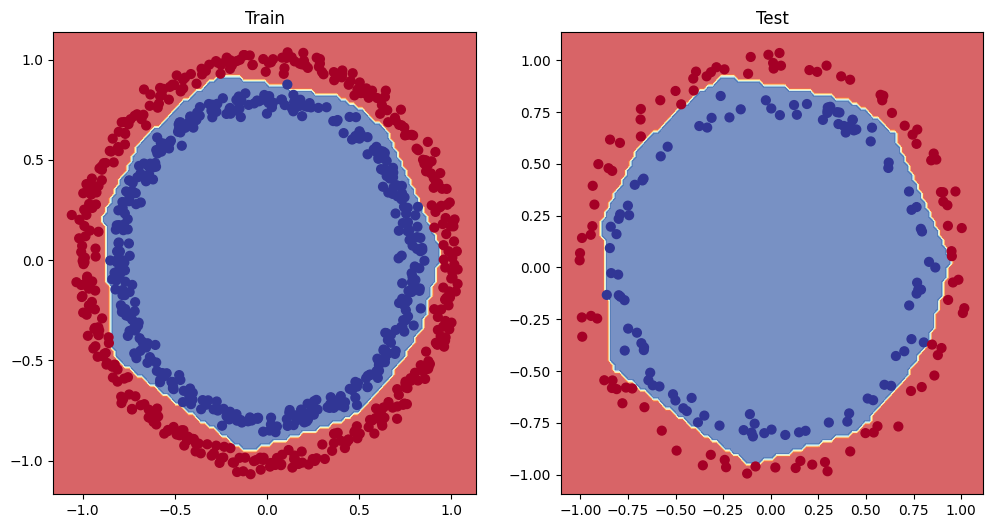

In [30]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,y_test)

Multi Class Classification


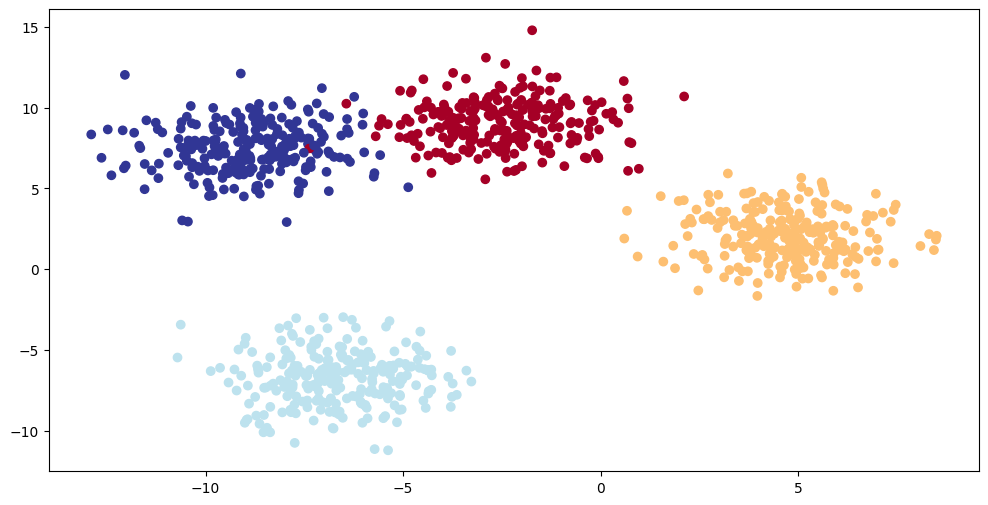

In [57]:
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
#Set hyperparameters
NUM_CLASSES=4
NUM_FEATURES=2
RANDOM_SEED=42
#Create multiclas data
X_blob,y_blob=make_blobs(n_samples=1000,
                         n_features=NUM_FEATURES,
                         centers=NUM_CLASSES,
                         cluster_std=1.5,
                         random_state=RANDOM_SEED)
#Turn data into tensors
X_blob=torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.long)

#Split data
X_blob_train,X_blob_test,y_blob_train,y_blob_test=train_test_split(X_blob,y_blob,
                                                                   test_size=0.2,
                                                                   random_state=RANDOM_SEED)
#Plot
plt.figure(figsize=(12,6))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

Multi-Class Classification Model

In [58]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [59]:
from torch import nn
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.linear_layer_stack=nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        #nn.ReLU()
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        #nn.ReLU()
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )
  def forward(self,x):
    return self.linear_layer_stack(x)

model4=BlobModel(input_features=NUM_FEATURES,
                 output_features=NUM_CLASSES,
                 hidden_units=8).to(device)

model4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [60]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model4.parameters(),
                          lr=0.1)

Logits->Prediction Probs->Argmax

In [61]:
y_logits=model4(X_blob_test.to(device))
y_pred_probs=torch.softmax(y_logits,dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [62]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


In [63]:
y_preds=torch.argmax(y_pred_probs,dim=1)
y_preds[:20]

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3],
       device='cuda:0')

Training and Testing Loop

In [64]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=100
X_blob_train,X_blob_test=X_blob_train.to(device),X_blob_test.to(device)
y_blob_train,y_blob_test=y_blob_train.to(device),y_blob_test.to(device)

for epoch in range(epochs):
  model4.train()
  y_logits=model4(X_blob_train)
  y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
  loss=loss_fn(y_logits,y_blob_train)
  acc=accuracy_fn(y_blob_train,y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model4.eval()
  with torch.inference_mode():
    test_logits=model4(X_blob_test)
    test_pred=torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss=loss_fn(test_logits,y_blob_test)
    test_acc=accuracy_fn(y_blob_test,test_pred)
    if epoch%10==0:
      print(f"Epoch:{epoch}|Loss:{loss:.5f},Accuracy:{acc:.2f}%|Test Loss:{test_loss:.5f},Test acc:{test_acc:.2f}")

Epoch:0|Loss:1.04324,Accuracy:65.50%|Test Loss:0.57861,Test acc:95.50
Epoch:10|Loss:0.14398,Accuracy:99.12%|Test Loss:0.13037,Test acc:99.00
Epoch:20|Loss:0.08062,Accuracy:99.12%|Test Loss:0.07216,Test acc:99.50
Epoch:30|Loss:0.05924,Accuracy:99.12%|Test Loss:0.05133,Test acc:99.50
Epoch:40|Loss:0.04892,Accuracy:99.00%|Test Loss:0.04098,Test acc:99.50
Epoch:50|Loss:0.04295,Accuracy:99.00%|Test Loss:0.03486,Test acc:99.50
Epoch:60|Loss:0.03910,Accuracy:99.00%|Test Loss:0.03083,Test acc:99.50
Epoch:70|Loss:0.03643,Accuracy:99.00%|Test Loss:0.02799,Test acc:99.50
Epoch:80|Loss:0.03448,Accuracy:99.00%|Test Loss:0.02587,Test acc:99.50
Epoch:90|Loss:0.03300,Accuracy:99.12%|Test Loss:0.02423,Test acc:99.50


Making and Evaluating Predictions

In [65]:
model4.eval()
with torch.inference_mode():
  y_logits=model4(X_blob_test)

y_preds=torch.softmax(y_logits,dim=1).argmax(dim=1)
print(y_pred[:10])
print(y_blob_test[:10])
print(f"Test accuracy:{accuracy_fn(y_true=y_blob_test,y_pred=y_preds)}")

tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0], device='cuda:0')
tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy:99.5


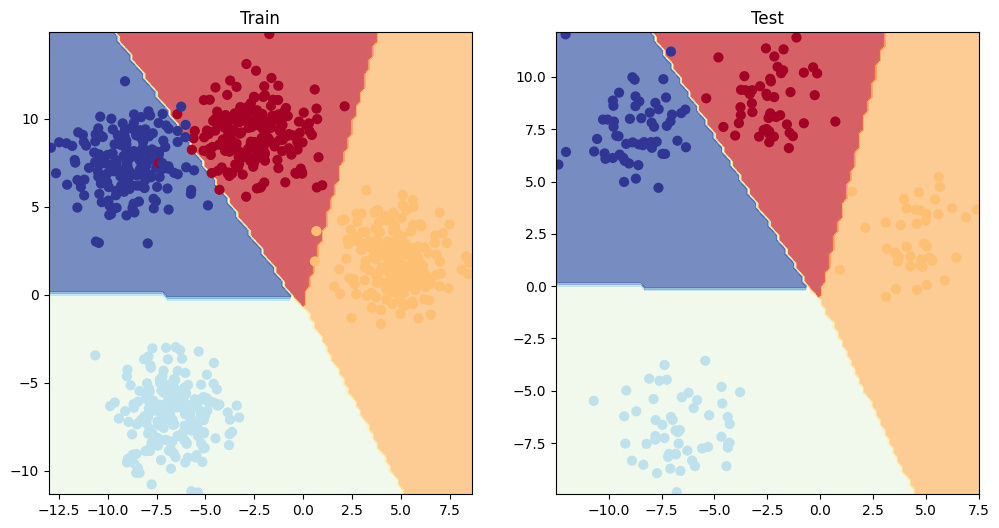

In [66]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model4,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model4,X_blob_test,y_blob_test)

TorchMetrics

In [68]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 5.9 MB/s eta 0:00:00


In [73]:
from torchmetrics import Accuracy
torchmetric_accuracy=Accuracy(task="multiclass",num_classes=4).to(device)
torchmetric_accuracy(y_preds,y_blob_test)

tensor(0.9950, device='cuda:0')